# Assignment 1 - class scheduling

## Initialization

In [249]:
import matplotlib.pyplot as plt

class Timeslot():
    def __init__(self, start, end, color, title):
        self.start = start
        self.end = end
        self.color = color
        self.title = title

def applyTimeslots(offset, limit, timeslots, ax):
    for timeslot in timeslots:
        ax.fill_between([offset + 0.05, limit - 0.05], [timeslot.start + 0.05, timeslot.start + 0.05], [timeslot.end - 0.05,timeslot.end - 0.05], color=timeslot.color, edgecolor='k', linewidth=0.5, alpha=0.4
                        )
        ax.text(float(limit - offset) / 2 + offset, (timeslot.start + timeslot.end) / 2, timeslot.title, ha="center", va="center", fontsize=12)
        
def plotDay(timeslots):
    width = 10
    height = 8
    
    fig = plt.figure(figsize=(width, height))
    
    margin = 0.3
    
    ax = fig.add_subplot(111)
    ax.yaxis.grid()
    ax.set_ylabel("Time")
    ax.axes.get_xaxis().set_visible(False)
    fig.gca().invert_yaxis()

    applyTimeslots(margin, width - margin, timeslots, ax)
    
    ax.set_title("Day")
    
    plt.show()
    
def plotWeek(timeslotDays, dayStartAndEnd = None):
    width = 15
    height = 8
    weekdays = 7
    
    fig = plt.figure(figsize=(width, height))
    
    margin = 0.3
    
    ax = fig.add_subplot(111)
    ax.yaxis.grid()
    
    if dayStartAndEnd != None:
        (start, end) = dayStartAndEnd
        
        plt.yticks(range(start, end + 1))
        fig.gca().set_ylim([start,end])
    
    ax.set_ylabel("Time")
    #ax.axes.get_xaxis().set_visible(False)
    
    fig.gca().invert_yaxis()
    
    dayWidth = width / weekdays
    
    def genDays(): 
        days = ["Monday", "Tuesday", "Wensday", "Thursday", "Friday", "Saturday", "Sunday"]
        
        
        fig.gca().set_xlim([0,len(days)])
        

        for i, day in enumerate(days):
            yield (day, i * dayWidth + (dayWidth / 2))
            
    tickedDays = list(genDays())
    
    plt.xticks(list(map(lambda x: x[1], tickedDays)), list(map(lambda x: x[0], tickedDays)))
    
    for i, dayTimeslots in enumerate(timeslotDays):
        offset = i * dayWidth
        
        applyTimeslots(offset, offset + dayWidth, dayTimeslots, ax)

    
    ax.set_title("Week")
    
    plt.show()
    
    

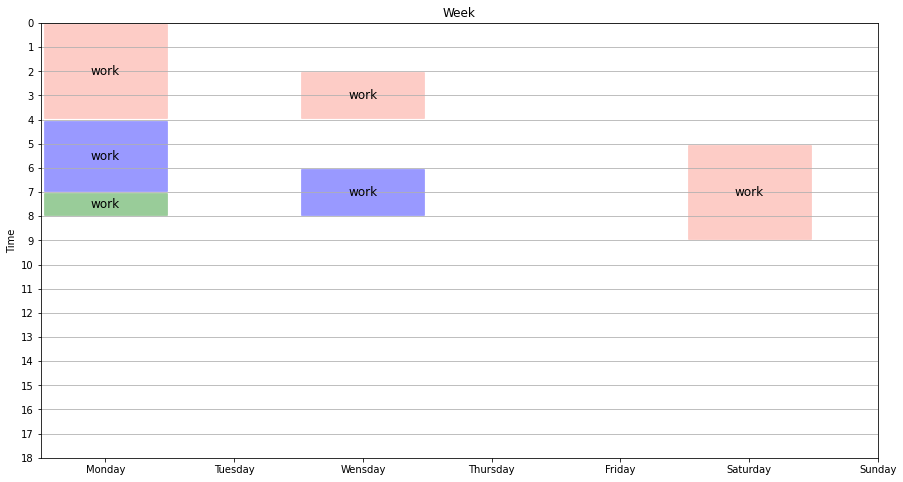

In [243]:
slots1 = [Timeslot(0, 4, "salmon", "work"), Timeslot(4, 7, "Blue", "work"), Timeslot(7, 8, "Green", "work")]
slots2 = []
slots3 = [Timeslot(2, 4, "salmon", "work"), Timeslot(6, 8, "Blue", "work")]
slots4 = []
slots5 = []
slots6 = [Timeslot(5, 9, "salmon", "work")]
slots7 = []

plotWeek([slots1, slots2, slots3, slots4, slots5, slots6, slots7], (0, 18))

## Model

## Initial description

We have:
* $P = (h,d,w)| h \in \text{Hours, } d \in \text{Days, } w \in \text{Weeks}$ 
* Rooms $R$
* Classes $E$ with duration $\ell(e), e \in E$
* Presedence digraph $D = (E, A)\text{, } uv \in A \text{ for } u, v \in E$
* Students $S$ and teachers $T$ with:
    * Enrollments $Q = E_s \subset E | s \in S$
    * Teaching duties $D = D_t \subset E | t \in T$
    * Unavailabilites $\mathcal{U} = U_t \subset P | t \in T$
    
Additionally I will use $B$ as the collection of busy rooms for a given time, eg $B = \{ B_p \subset R \,|\, p \in P \}$

## Model interpretation

All classes should be allocated.
$$x_{erp} \in \{0, 1\}$$
$$\sum_{p \in P, r \in R} x_{erp} = 1, \forall e \in E$$

Classes should never overlap and range their full duration.
$$\sum_{e \in E} \, \sum^h_{i=max(0, h - \ell(e) + 1)} x_{e,r,(i,d,w)} \leq 1, \, \forall (h,d,w) \in P, \, \forall r \in R$$

A teacher may not teach two classes at the same time, no more than one room may ever be occupied by a class that requires the same teacher within the entire timeframe of a lecture.
$$\sum_{e \in d_e} \, \sum_{r \in R} \, \sum^h_{i=max(0, h - \ell(e) + 1)} x_{e,r,(i,d,w)} \leq 1, \, \forall (h,d,w) \in P, \, \forall d_e\in D$$

A busy room should never be occupied.
$$x_{e,r,(i,d,w)} ,\, e \in E ,\, \forall (h,d,w) \in P ,\, \forall b_r \in B$$

A teacher may not be allocated during an unavailability.
$$\sum , \, u \in U$$

There is at most one event per day per course.
$$\sum e_{dc} \leq 1, \forall d \in D, \, \forall c \in C$$

Classes must take presedence (day for class $u$ must be before day for class $v$, in week $w$ (I am unsure if the presedence graph takes weeks into account, so I'm explicit)).
$$d_{uw} < d_{vw}, \forall uv \in A, \, (\_, d, w) \in P, \, u,v \in E $$

Teachers may not be allocated when not available.
$$t_{hdw} = 0, \, (h,d,w) \in U_t, \, t \in T $$

Teachers should teach their respective class, thus a teacher should be allocated at the same time as a given class they teach.
$$t = 1 \land e  = 1, \, \forall e \in D_t, \, t \in T$$

Students should (try to) attend a class, this is the first soft constraint since overlapping classes cannot be avoided.\
We use a variable to express how many classes a student is attending at once, which should be minimized.\
First we express the amount of overlapping classes at a given time.
$$c_{s,(h,d,w)} = \sum e_{(h,d,w)} - 1, \, e \in Q_s$$
Then we do all time + student combinations.
$$a = \sum c_{s,(h,d,w)}, \, s \in S, \, (h,d,w) \in P$$

## Code

### Initilization

In [191]:
import pyomo.environ as po
import src.data as imp
import time

dataImporter = imp.Data("data/small")

slots = dataImporter.slots
banned = dataImporter.banned
events = dataImporter.events
teachers = dataImporter.teachers
students = dataImporter.students
rooms = dataImporter.rooms

In [48]:
test_slots = []

hrs = 8
dur = 2
week = 6

test_rooms = ["one", "two"]

for i in range(hrs):
    test_slots.append({
        "day": 0,
        "week": week,
        "hour": i
    })

es = []

for i in range(int(hrs / 2) * len(test_rooms) + 1):
    es.append({
        'duration': dur, 
        'id': 'test-id-' + str(i), 
        'paired': [], 
        'section': 'test-section', 
        'week': week
    })
    
test_events = {"test-course": es}

In [213]:
class ModelDataMapping:
    def __init__(self, E, P, R, D, T, namedEvents, model, result, indexedRooms, teacherPairs, courseIdToTeacherMapping):
        self.E = E
        self.P = P
        self.R = R
        self.D = D
        self.T = T
        self.namedEvents = namedEvents
        self.indexedRooms = indexedRooms
        self.model = model
        self.result = result
        self.teacherPairs = teacherPairs
        self.courseIdToTeacherMapping = courseIdToTeacherMapping

def prepareModel(events, students, teachers, slots, banned, rooms):
    print("Preparing data")
    rooms_as_list = list(rooms.items())
    
    R = list(range(len(rooms_as_list)))
    namedEvents = [(eventSet, e) for eventSet in events for e in events[eventSet]]
    E = list(range(len(namedEvents)))
    P = [(s["hour"], s["day"], s["week"]) for s in slots]
    preparedBanned = [(b["hour"], b["day"], b["week"]) for b in banned]
    
    eventIdToIndex = dict([(e[1]["id"], i) for i, e in enumerate(namedEvents)])
    teacherPairs = list(teachers.items())
    T = range(len(teacherPairs))

    def indexedTeacherEvents():
        for teacherId, eventsForTeacher in teacherPairs:
            onlyEvents = [e["events"] for e in eventsForTeacher]

            flattenedEvents = [eventIdToIndex[b] for a in onlyEvents for b in a]

            yield flattenedEvents
    
    D = list(indexedTeacherEvents())
    
    # courseId to teacher mapping
    courseIdToTeacherMapping = [ [] for i in range(len(E)) ]

    for teacherIdx, d in enumerate(D):
        for e in d:
            courseToTeacherMapping[e].append(teacherIdx)
    
    print("Generating 5d/3d matrix of size", len(E) * len(R) * len(P))
    domain = [(e, r, p[0], p[1], p[2]) for e in E for r in R for p in P]
    
    m = po.ConcreteModel("timetable")
    
    print("Adding variable")
    m.x = po.Var(domain, bounds = (0, 1), within=po.Binary)
    
    m.value = po.Objective(expr=sum(m.x[(e,r,p)] * p[2] for e in E for r in R for p in P), sense=po.minimize)
    
    m.scheduled = po.ConstraintList()
    
    print("Adding scheduled constraint")
    
    for e in E:
        m.scheduled.add(expr = sum(m.x[(e,r,p)] for p in P for r in R) == 1)
        
    def duration(eventIndex):
        return namedEvents[eventIndex][1]["duration"]
    
    
    m.only_teach_one_class = po.ConstraintList()
    
    print("Adding teacher only teaches one class at a time constriants")
    for teacherIdx, de in enumerate(D):
        print("Adding constraint for teacher", teacherIdx)
        for p in P:
            (h, d, w) = p

            m.only_teach_one_class.add(sum(sum(sum(m.x[(e,r,(i, d, w))] for i in range(max(0, h - duration(e) + 1), h + 1)) for r in R) for e in de) <= 1)
    
    m.overlap = po.ConstraintList()
    
    print("Adding overlap constriants")
    for r in R:
        print("Adding constraints for room", r)
        for p in P:
            (h, d, w) = p

            m.overlap.add(sum(sum(m.x[(e,r,(i, d, w))] for i in range(max(0, h - duration(e) + 1), h + 1)) for e in E) <= 1)
    
            
    print("Solving...")    
        
    now = time.time()
        
    res = po.SolverFactory("gurobi").solve(m, tee=(False))
    
    o = ModelDataMapping(E, P, R, D, T, namedEvents, m, res, rooms_as_list, teacherPairs, courseIdToTeacherMapping)
    
    later = time.time()
    difference = int(later - now)
    
    print("Done in", difference, "seconds")
            
    return o
            
    

In [214]:
modelDataMapping = prepareModel(events, students, teachers, slots, banned, rooms)
#modelDataMapping = prepareModel(test_events, {}, {}, test_slots, [], test_rooms)

Preparing data
Generating 5d/3d matrix of size 2419200
Adding variable
Adding scheduled constraint
Adding teacher only teaches one class at a time constriants
Adding constraint for teacher 0
Adding constraint for teacher 1
Adding constraint for teacher 2
Adding constraint for teacher 3
Adding constraint for teacher 4
Adding constraint for teacher 5
Adding constraint for teacher 6
Adding constraint for teacher 7
Adding overlap constriants
Adding constraints for room 0
Adding constraints for room 1
Adding constraints for room 2
Adding constraints for room 3
Adding constraints for room 4
Adding constraints for room 5
Adding constraints for room 6
Adding constraints for room 7
Adding constraints for room 8
Adding constraints for room 9
Adding constraints for room 10
Adding constraints for room 11
Adding constraints for room 12
Adding constraints for room 13
Solving...
Done in 96 seconds


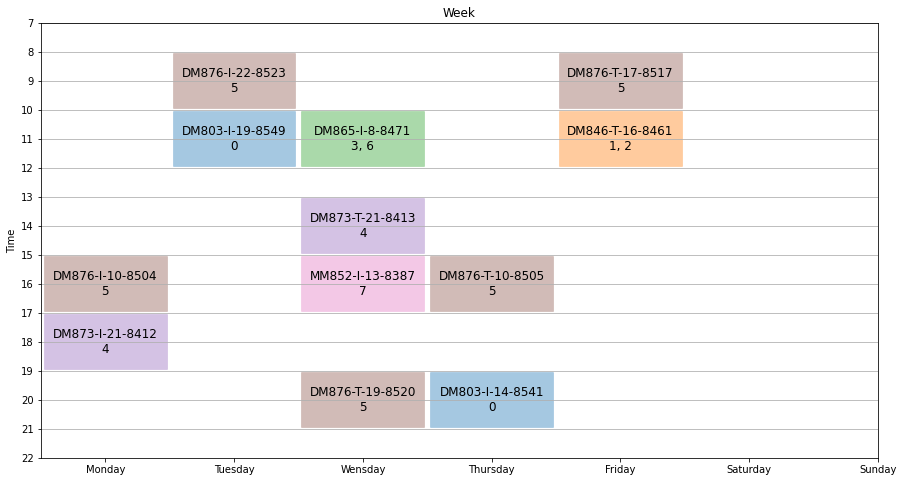

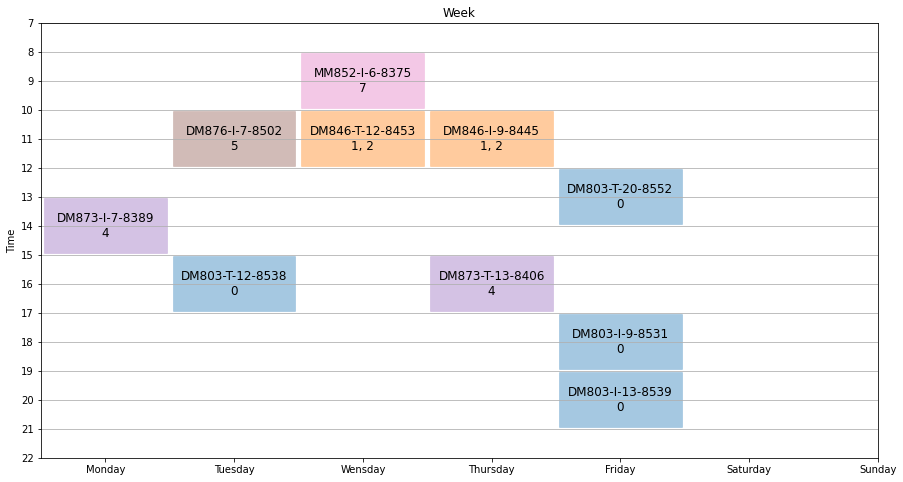

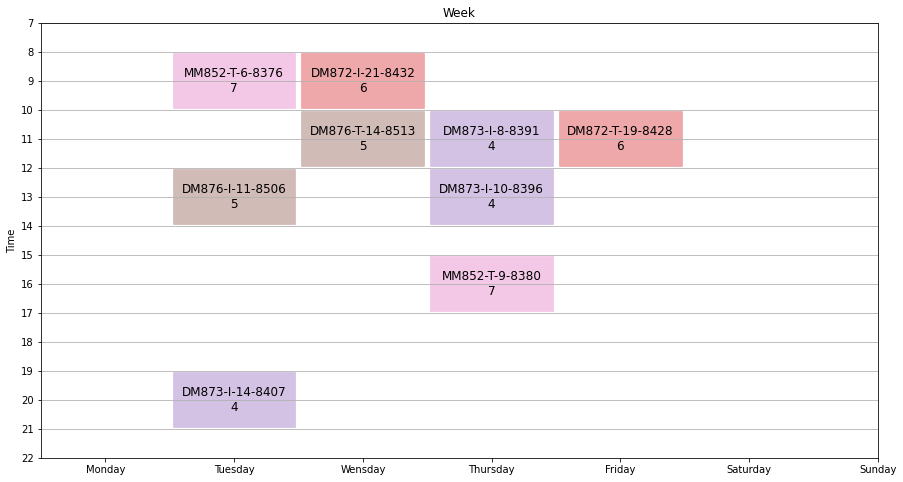

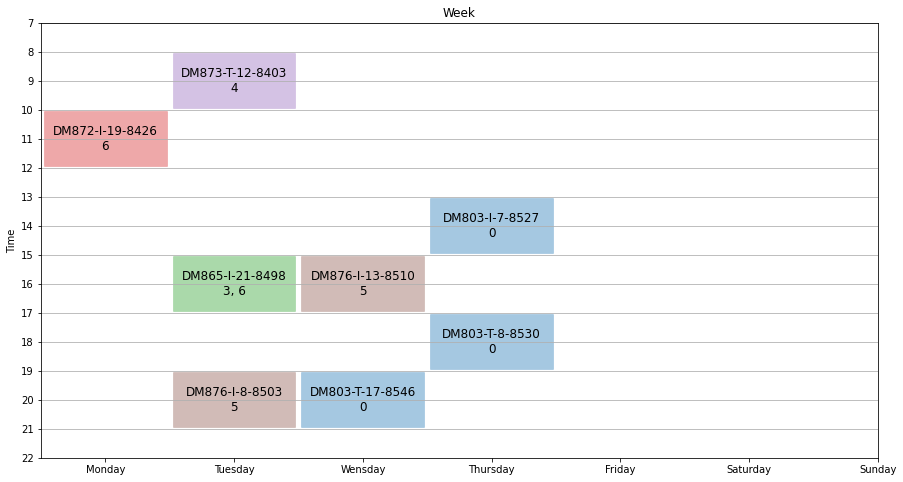

In [253]:
import matplotlib.colors as mcolors

color_map = {}

colorsAsList = list(mcolors.TABLEAU_COLORS.items())

for i, k in enumerate(events):
    color_map[k] = colorsAsList[i]
    
dayStart = 8
    
def plotFor(week, room):
    timeslots = [ [] for i in range(7) ]

    # plot data
    for e in modelDataMapping.E:
        for r in modelDataMapping.R:
            if r != room:
                continue

            for (h, d, w) in modelDataMapping.P:
                if w != week:
                    continue

                value = po.value(modelDataMapping.model.x[e,r,h,d,w])

                if value != 0:
                    namedEvent = modelDataMapping.namedEvents[e]

                    color = color_map[namedEvent[0]]

                    teachersThatCanTeachThis = [str(teacherIdx) for teacherIdx in courseToTeacherMapping[e]]

                    timeslots[d].append(Timeslot(h + dayStart, h + dayStart + namedEvent[1]["duration"], color, namedEvent[1]["id"] + "\n" + ", ".join(teachersThatCanTeachThis)))

    plotWeek(timeslots, (7, 22))

plotFor(week=6, room=1)  
plotFor(week=6, room=2)
plotFor(week=6, room=3)
plotFor(week=6, room=4)


## 